# CoDaS-HEP Columnar Data Analysis, hands-on project

This is the third of four notebooks on [columnar data analysis](https://indico.cern.ch/event/1287965/timetable/#41-columnar-data-analysis), presented at CoDaS-HEP at 13:30pm on July 20, 2023 by Jim Pivarski and Ioana Ifrim.

See the [GitHub repo](https://github.com/ioanaif/columnar-data-analysis-codas-hep-2023) for instructions on how to run it.

<br><br><br><br><br>

## Project: H → ZZ → 4ℓ

In this exercise, we'll reconstruct Z masses and the Higgs mass from four leptons (4μ, 4e, 2μ2e).

<br><br><br><br><br>

### Getting the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hist

In [2]:
import awkward as ak
import vector
vector.register_awkward()

In [3]:
raw_data = ak.from_parquet("../data/SMHiggsToZZTo4L.parquet")

In [4]:
raw_data.show()

[{run: 1, luminosityBlock: 156, event: 46501, PV_npvs: 15, PV_x: 0.244, ...},
 {run: 1, luminosityBlock: 156, event: 46502, PV_npvs: 13, PV_x: 0.244, ...},
 {run: 1, luminosityBlock: 156, event: 46503, PV_npvs: 11, PV_x: 0.242, ...},
 {run: 1, luminosityBlock: 156, event: 46504, PV_npvs: 22, PV_x: 0.243, ...},
 {run: 1, luminosityBlock: 156, event: 46505, PV_npvs: 18, PV_x: 0.24, ...},
 {run: 1, luminosityBlock: 156, event: 46506, PV_npvs: 5, PV_x: 0.243, ...},
 {run: 1, luminosityBlock: 156, event: 46507, PV_npvs: 11, PV_x: 0.242, ...},
 {run: 1, luminosityBlock: 156, event: 46508, PV_npvs: 25, PV_x: 0.245, ...},
 {run: 1, luminosityBlock: 156, event: 46509, PV_npvs: 12, PV_x: 0.246, ...},
 {run: 1, luminosityBlock: 156, event: 46510, PV_npvs: 18, PV_x: 0.244, ...},
 ...,
 {run: 1, luminosityBlock: 996, event: 298792, PV_npvs: 24, PV_x: 0.244, ...},
 {run: 1, luminosityBlock: 996, event: 298793, PV_npvs: 14, PV_x: 0.242, ...},
 {run: 1, luminosityBlock: 996, event: 298794, PV_npvs: 24

In [5]:
raw_data.type.show()

299973 * {
    run: int32,
    luminosityBlock: int64,
    event: uint64,
    PV_npvs: int32,
    PV_x: float32,
    PV_y: float32,
    PV_z: float32,
    nMuon: int64,
    Muon_pt: var * float32,
    Muon_eta: var * float32,
    Muon_phi: var * float32,
    Muon_mass: var * float32,
    Muon_charge: var * int32,
    Muon_pfRelIso03_all: var * float32,
    Muon_pfRelIso04_all: var * float32,
    Muon_dxy: var * float32,
    Muon_dxyErr: var * float32,
    Muon_dz: var * float32,
    Muon_dzErr: var * float32,
    nElectron: int64,
    Electron_pt: var * float32,
    Electron_eta: var * float32,
    Electron_phi: var * float32,
    Electron_mass: var * float32,
    Electron_charge: var * int32,
    Electron_pfRelIso03_all: var * float32,
    Electron_dxy: var * float32,
    Electron_dxyErr: var * float32,
    Electron_dz: var * float32,
    Electron_dzErr: var * float32,
    MET_pt: float32,
    MET_phi: float32
}


<br><br><br><br><br>

### Reformatting for more object-oriented arrays

Vector requires arrays to be formatted with fields named `pt`, `phi`, `eta`, `mass` with name `"Momentum4D"`. [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html) can do that.

They don't need `charge` or isolation variables, but having extra fields is not a problem.

In [6]:
events = ak.zip({
    "PV": ak.zip({
        "x": raw_data["PV_x"],
        "y": raw_data["PV_y"],
        "z": raw_data["PV_z"],
    }, with_name="Vector3D"),
    "muons": ak.zip({
        "pt": raw_data["Muon_pt"],
        "phi": raw_data["Muon_phi"],
        "eta": raw_data["Muon_eta"],
        "mass": raw_data["Muon_mass"],
        "charge": raw_data["Muon_charge"],
        "pfRelIso03": raw_data["Muon_pfRelIso03_all"],
        "pfRelIso04": raw_data["Muon_pfRelIso04_all"],
    }, with_name="Momentum4D"),
    "electrons": ak.zip({
        "pt": raw_data["Electron_pt"],
        "phi": raw_data["Electron_phi"],
        "eta": raw_data["Electron_eta"],
        "mass": raw_data["Electron_mass"],
        "charge": raw_data["Electron_charge"],
        "pfRelIso03": raw_data["Electron_pfRelIso03_all"],
    }, with_name="Momentum4D"),
    "MET": ak.zip({
        "pt": raw_data["MET_pt"],
        "phi": raw_data["MET_phi"],
    }, with_name="Momentum2D"),
}, depth_limit=1)

events

<Array [{PV: {...}, muons: [...], ...}, ...] type='299973 * {PV: Vector3D[x...'>

<br><br><br><br><br>

With `.show()`, we can get a sense of the structure of the events.

In [7]:
events.show()

[{PV: {x: 0.244, y: 0.394, z: 1.45}, muons: [{...}, ...], electrons: [], ...},
 {PV: {x: 0.244, y: 0.395, z: ..., ...}, muons: [], electrons: [...], ...},
 {PV: {x: 0.242, y: 0.395, z: 1.87}, muons: [], electrons: [...], ...},
 {PV: {x: 0.243, y: 0.393, z: ..., ...}, muons: [{...}, ...], ...},
 {PV: {x: 0.24, y: 0.391, z: 7.06}, muons: [], electrons: [...], MET: ..., ...},
 {PV: {x: 0.243, y: 0.392, z: ..., ...}, muons: [{...}, ...], ...},
 {PV: {x: 0.242, y: 0.391, z: ..., ...}, muons: [{...}], electrons: ..., ...},
 {PV: {x: 0.245, y: 0.391, z: ..., ...}, muons: [], electrons: [{...}], ...},
 {PV: {x: 0.246, y: 0.391, z: 3.01}, muons: [], electrons: [...], ...},
 {PV: {x: 0.244, y: 0.395, z: 1.41}, muons: [], electrons: [], MET: {...}},
 ...,
 {PV: {x: 0.244, y: 0.394, z: ..., ...}, muons: [{...}, ...], ...},
 {PV: {x: 0.242, y: 0.394, z: ..., ...}, muons: [{...}, ...], ...},
 {PV: {x: 0.245, y: 0.394, z: ..., ...}, muons: [{...}, ...], ...},
 {PV: {x: 0.245, y: 0.391, z: ..., ...}, 

<br><br><br><br><br>

### Vector calculations and plotting

Since we have called `vector.register_awkward()` and named these records `"Momentum4D"`, they also have a momentum interpretation.

In [8]:
events.electrons.pt   # this is one of the fields (returned as-is)

<Array [[], [21.9, ..., 23.8], ..., [48.1, 38.7]] type='299973 * var * float32'>

In [9]:
events.electrons.pz   # this is in a different coordinate system (computed)

<Array [[], [-16.7, ..., -43.5], ..., [26.8, 74]] type='299973 * var * float32'>

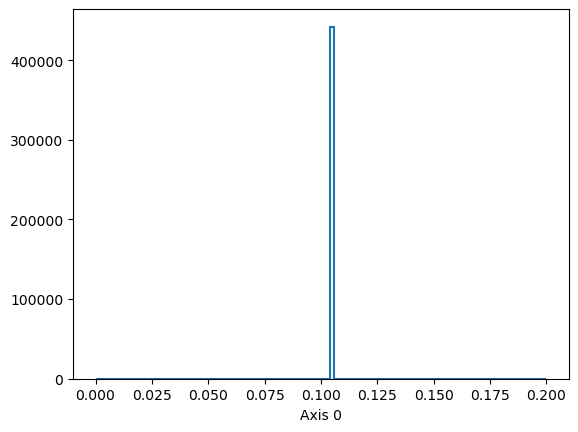

In [10]:
hist.Hist.new.Regular(100, 0, 0.2).Double().fill(ak.ravel(events.muons.mass)).plot();     # one of the fields

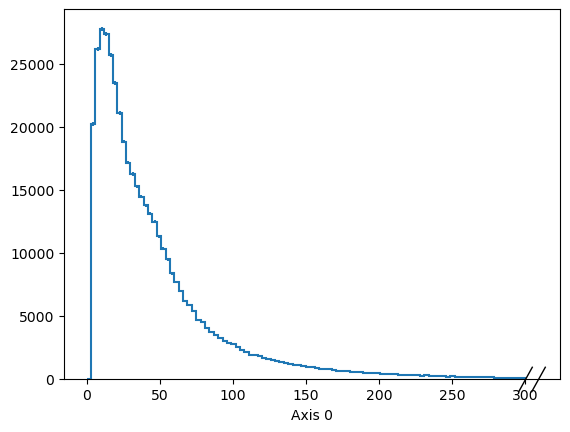

In [11]:
hist.Hist.new.Regular(100, 0, 300).Double().fill(ak.ravel(events.muons.energy)).plot();   # computed

<br><br><br><br><br>

Also added PV (primary vertexes) and MET (missing energy).

The primary vertexes are geometric, not momentum, so you have to say `x` instead of `px`, `rho` instead of `pt`, etc.

In [12]:
events.MET.px, events.MET.py

(<Array [-20.1, -16.3, -10.7, ..., -5.53, -9.41, -1.04] type='299973 * float32'>,
 <Array [-8.77, 4.6, -15.8, ..., 16.8, -22.1, 12.9] type='299973 * float32'>)

In [13]:
events.PV.rho

<Array [0.463, 0.465, 0.464, ..., 0.462, 0.459, 0.463] type='299973 * float32'>

In [14]:
abs(events.PV)

<Array [1.52, 2.92, 1.92, 7.9, ..., 2.11, 5.07, 6.53] type='299973 * float32'>

In [15]:
beamspot_x, beamspot_y, beamspot_z = ak.mean(events.PV.x), ak.mean(events.PV.y), ak.mean(events.PV.z)
beamspot_x, beamspot_y, beamspot_z

(0.24391455647674956, 0.3925532985468692, 0.41964240323295765)

In [16]:
beamspot_PV = ak.zip({
    "x": events.PV.x - beamspot_x,
    "y": events.PV.y - beamspot_y,
    "z": events.PV.z - beamspot_z,
}, with_name="Vector3D")
beamspot_PV

<VectorArray3D [{x: -0.000216, y: 0.00115, ...}, ...] type='299973 * Vector...'>

<br><br><br><br><br>

You can add new columns to an existing array of records...

In [17]:
events["beamspot_PV"] = beamspot_PV

In [18]:
events[0].tolist()

{'PV': {'x': 0.24369880557060242,
  'y': 0.3936990201473236,
  'z': 1.451307773590088},
 'muons': [{'pt': 63.04386901855469,
   'phi': 2.968005895614624,
   'eta': -0.7186822295188904,
   'mass': 0.10565836727619171,
   'charge': 1,
   'pfRelIso03': 0.0,
   'pfRelIso04': 0.0},
  {'pt': 38.12034606933594,
   'phi': -1.0324749946594238,
   'eta': -0.8794569969177246,
   'mass': 0.10565836727619171,
   'charge': -1,
   'pfRelIso03': 0.0,
   'pfRelIso04': 0.0},
  {'pt': 4.04868745803833,
   'phi': 1.0385035276412964,
   'eta': -0.320764422416687,
   'mass': 0.10565836727619171,
   'charge': 1,
   'pfRelIso03': 0.0,
   'pfRelIso04': 0.17997965216636658}],
 'electrons': [],
 'MET': {'pt': 21.929929733276367, 'phi': -2.7301223278045654},
 'beamspot_PV': {'x': -0.00021575391292572021,
  'y': 0.0011457204818725586,
  'z': 1.031665325164795}}

...but you usually don't have to.

It would have been just as easy to work with `events` and `beamspot_PV` as separate Python variables.

Unless you want to make sure that a cut is applied to each (and don't want to slice both `events` and `beamspot_PV` separately).

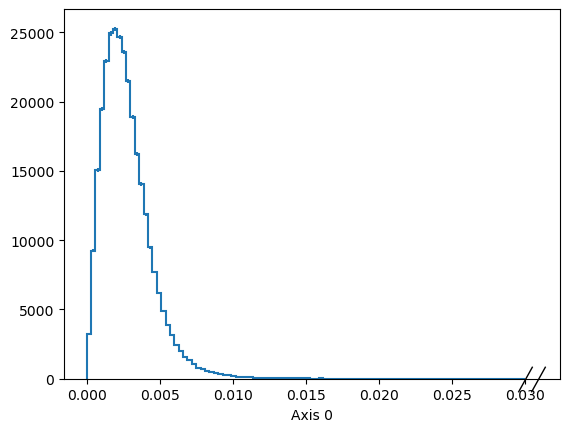

In [19]:
hist.Hist.new.Regular(100, 0, 0.03).Double().fill(beamspot_PV.rho).plot();

In [20]:
beamspot_PV.rho < 0.008

<Array [True, True, True, True, ..., True, True, True] type='299973 * bool'>

In [21]:
events[beamspot_PV.rho < 0.008]

<Array [{PV: {...}, muons: [...], ...}, ...] type='295935 * {PV: Vector3D[x...'>

The above selected all fields in `events`. With `events` and `beamspot_PV` as separate arrays, they'd have to both be sliced.

<br><br><br><br><br>

In [22]:
events.muons

<MomentumArray4D [[{pt: 63, phi: 2.97, ...}, ...], ...] type='299973 * var ...'>

### Combinatorics

It's possible to use slices to pick the first and second muon of each event...

In [23]:
events.muons[:, 0]

IndexError: cannot slice ListArray (of length 299973) with array(0): index out of range while attempting to get index 0 (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-21/awkward-cpp/src/cpu-kernels/awkward_NumpyArray_getitem_next_at.cpp#L21)

This error occurred while attempting to slice

    <MomentumArray4D [[{pt: 63, phi: 2.97, ...}, ...], ...] type='299973 * ...'>

with

    (:, 0)

...but only after ensuring that the events _have_ 2 muons (using [ak.num](https://awkward-array.readthedocs.io/en/latest/_auto/ak.num.html)).

In [24]:
ak.num(events.muons)

<Array [3, 0, 0, 7, 0, 2, 1, 0, ..., 2, 0, 2, 2, 4, 0, 0] type='299973 * int64'>

In [25]:
ak.num(events.muons) >= 2

<Array [True, False, False, True, ..., True, False, False] type='299973 * bool'>

In [26]:
events[ak.num(events.muons) >= 2]

<Array [{PV: {...}, muons: [...], ...}, ...] type='145597 * {PV: Vector3D[x...'>

In [27]:
events[ak.num(events.muons) >= 2].muons[:, 0]

<MomentumArray4D [{pt: 63, phi: 2.97, ...}, ..., {...}] type='145597 * Mome...'>

The following is equivalent, doing the selection for at least two muons and the selection for the first muon in a single slice.

In [28]:
events.muons[ak.num(events.muons) >= 2, 0]

<MomentumArray4D [{pt: 63, phi: 2.97, ...}, ..., {...}] type='145597 * Mome...'>

In [29]:
first_muons, second_muons = (
    events.muons[ak.num(events.muons) >= 2, 0],
    events.muons[ak.num(events.muons) >= 2, 1],
)

In [30]:
first_muons + second_muons

<MomentumArray4D [{rho: 47.8, phi: -2.67, ...}, ...] type='145597 * Momentu...'>

In [31]:
(first_muons + second_muons).mass

<Array [89.5, 29.8, 87.1, 90.5, ..., 27.9, 90.5, 2.4] type='145597 * float32'>

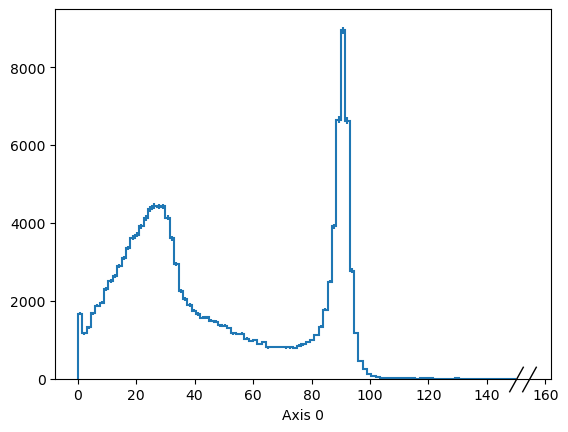

In [32]:
hist.Hist.new.Regular(100, 0, 150).Double().fill((first_muons + second_muons).mass).plot();

<br><br><br><br><br>

Although we see a nice Z peak, there are a couple of problems with the above.

   * You have to keep track of which arrays you've required to have two muons and which you haven't. If you try to do calculations with an array that has been cut and another array that hasn't been cut (or has been cut differently), they won't align and you'll get an error.
   * The first and second muons in the list aren't necessarily daughters of the same Z.

You'll want to compute combinations within the collections, separately for each event.

<br><br>

Awkward Array has two combinatorial primitives:

<table style="margin-left: 0px">
    <tr style="background: white"><td style="font-size: 1.75em; font-weight: bold; text-align: center"><a href="https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html">ak.cartesian</a></td><td style="font-size: 1.75em; font-weight: bold; text-align: center"><a href=\"https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html\">ak.combinations</a></td></tr>
    <tr style="background: white"><td><img src="../img/cartoon-cartesian.svg" width="300"></td><td><img src="../img/cartoon-combinations.svg" width="300"></td></tr>
</table>

In [33]:
ak.cartesian(([[1, 2, 3], [], [4]], [["a", "b"], ["c"], ["d", "e"]])).tolist()

[[(1, 'a'), (1, 'b'), (2, 'a'), (2, 'b'), (3, 'a'), (3, 'b')],
 [],
 [(4, 'd'), (4, 'e')]]

In [34]:
ak.combinations([[1.1, 2.2, 3.3, 4.4], [], [5.5, 6.6]], 2).tolist()

[[(1.1, 2.2), (1.1, 3.3), (1.1, 4.4), (2.2, 3.3), (2.2, 4.4), (3.3, 4.4)],
 [],
 [(5.5, 6.6)]]

<br><br>

Note the data type of what this creates: tuples (_not lists_) of the left and right of each pairing.

In [35]:
print(ak.cartesian(([[1, 2, 3], [], [4]], [["a", "b"], ["c"], ["d", "e"]])).type)

3 * var * (int64, string)


In [36]:
print(ak.combinations([[1.1, 2.2, 3.3, 4.4], [], [5.5, 6.6]], 2).type)

3 * var * (float64, float64)


<br><br>

There is a different number of combinations than there are of objects in the original lists.

It's often useful to get all the lefts of each tuple into one array and all the rights of each tuple into another array (with [ak.unzip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.unzip.html) or slicing with `"0"` and `"1"`).

In [37]:
lefts, rights = ak.unzip(ak.cartesian(([[1, 2, 3], [], [4]], [["a", "b"], ["c"], ["d", "e"]])))

In [38]:
lefts

<Array [[1, 1, 2, 2, 3, 3], [], [4, 4]] type='3 * var * int64'>

In [39]:
rights

<Array [['a', 'b', 'a', 'b', 'a', 'b'], [], [...]] type='3 * var * string'>

In [40]:
ak.num(lefts), ak.num(rights)

(<Array [6, 0, 2] type='3 * int64'>, <Array [6, 0, 2] type='3 * int64'>)

<br>

In [41]:
pairs = ak.combinations([[1.1, 2.2, 3.3, 4.4], [], [5.5, 6.6]], 2)

In [42]:
pairs["0"]   # NOT pairs[0], the string "0" is the NAME of the first tuple field

<Array [[1.1, 1.1, 1.1, 2.2, 2.2, 3.3], ..., [5.5]] type='3 * var * float64'>

In [43]:
pairs["1"]

<Array [[2.2, 3.3, 4.4, 3.3, 4.4, 4.4], ..., [6.6]] type='3 * var * float64'>

In [44]:
ak.num(pairs["0"]), ak.num(pairs["1"])

(<Array [6, 0, 1] type='3 * int64'>, <Array [6, 0, 1] type='3 * int64'>)

<br><br><br><br><br>

And so...

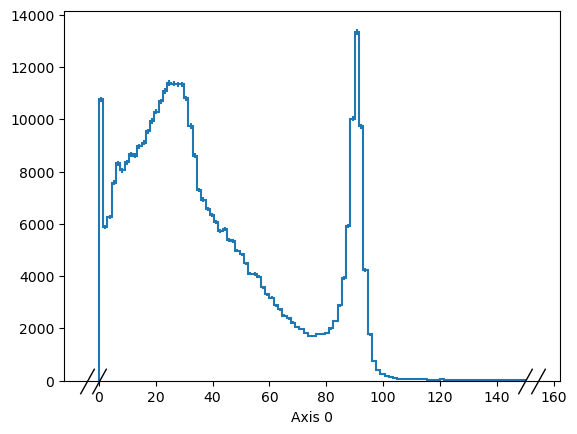

In [45]:
mu1, mu2 = ak.unzip(ak.combinations(events.muons, 2))
hist.Hist.new.Regular(100, 0, 150).Double().fill(ak.ravel((mu1 + mu2).mass)).plot();

In the above, we're looking at all combinations of 2 muons in H → ZZ → 4μ, 4e, or 2μ2e.

Some of these combinations even have the wrong charges.

In [46]:
mu1.charge + mu2.charge

<Array [[0, 2, 0], [], [], ..., [0, ...], [], []] type='299973 * var * int32'>

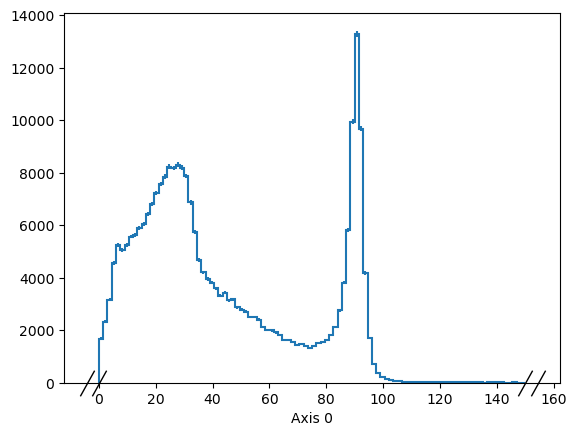

In [47]:
hist.Hist.new.Regular(100, 0, 150).Double().fill(ak.ravel((mu1 + mu2)[mu1.charge + mu2.charge == 0].mass)).plot();

In the above, we're only looking at μ⁺μ⁻, but some of those pairs have a μ⁺ from one Z and a μ⁻ from the other Z.

That wouldn't happen in the 2μ2e final state.

In [48]:
event_selection = ak.num(events.electrons) >= 2
event_selection

<Array [False, True, True, False, ..., False, True, True] type='299973 * bool'>

In [49]:
candidate_selection = mu1[event_selection].charge + mu2[event_selection].charge == 0
candidate_selection

<Array [[], [], [], [], [], ..., [True], [], [], []] type='137140 * var * bool'>

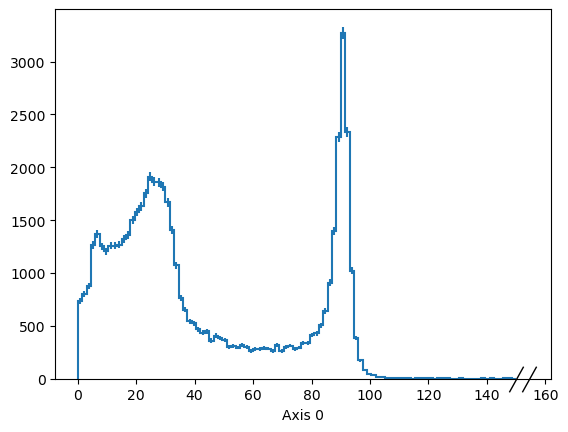

In [50]:
mumu_candidates_in_2mu2e = (mu1[event_selection] + mu2[event_selection])[candidate_selection]

hist.Hist.new.Regular(100, 0, 150).Double().fill(ak.ravel(mumu_candidates_in_2mu2e.mass)).plot();

There are still some non-Z muon pairs in this sample, but maybe isolation or a minimum $p_T$ would clean that up.

<br><br><br><br><br>

# Next stop: the hands-on project

Go to [project-workbook.ipynb](project-workbook.ipynb) for the hands-on project.